In [1]:
import numpy as np
import shapely
import pedpy
import matplotlib.pyplot as plt
import xkcd
import pathlib
from matplotlib.patches import Ellipse, Circle
# from math import atan2, degrees

# Load trajectory

In [2]:
# traj = pedpy.load_trajectory(trajectory_file=pathlib.Path("poster/UO/uo-180-180-095/uo-180-180-095_combined_MB.txt"), default_frame_rate=16., default_unit=pedpy.TrajectoryUnit.CENTIMETER)

In [3]:
# traj = pedpy.load_trajectory(trajectory_file=pathlib.Path("poster/UO/uo-240-240-100/uo-240-240-100_combined_MB.txt"), default_frame_rate=16., default_unit=pedpy.TrajectoryUnit.CENTIMETER)

In [5]:
# traj = pedpy.load_trajectory(trajectory_file=pathlib.Path("poster/uni-directional/traj_UNI_CORR_500_05.txt"), default_unit=pedpy.TrajectoryUnit.METER)

In [6]:
# traj = pedpy.load_trajectory(trajectory_file=pathlib.Path("poster/entrance.txt"), default_unit=pedpy.TrajectoryUnit.CENTIMETER)

In [7]:
# traj = pedpy.load_trajectory(trajectory_file=pathlib.Path("issues/001_ezel/2C070_cam6_cam5_frameshift0_Combined.txt"))

In [4]:
traj = pedpy.load_trajectory(trajectory_file=pathlib.Path("poster/UO/uo-300-300-120/uo-300-300-120_combined_MB.txt"), default_frame_rate=16., default_unit=pedpy.TrajectoryUnit.CENTIMETER)

In [9]:
geometry = pedpy.Geometry(walkable_area=shapely.Polygon([
    [0, -4], [0, 4], [-1, 4], [-1, 8], [4, 8], [4, 4], [3, 4], [3, -4], [2.1, -4], [2.1, -6], [0.9, -6], [0.9, -4]
]
))

In [10]:
walkable_area = shapely.Polygon([[-1, 8.5], [4, 8.5], [4, -7], [-1, -7]])

geometry = pedpy.Geometry(walkable_area=walkable_area)
line_left = shapely.LineString([[0, 4], [0, -4], [0.9, -4]])
obstacle_left = line_left.buffer(-0.2, single_sided=True, cap_style='square')
geometry.add_obstacle(obstacle_left)
line_right = shapely.LineString([[3, 4], [3, -4], [2.1, -4]])
obstacle_right = line_right.buffer(0.2, single_sided=True, cap_style='square')
geometry.add_obstacle(obstacle_right)

(-3.7750190000000003, 4.370239, -8.397415, 22.345715)

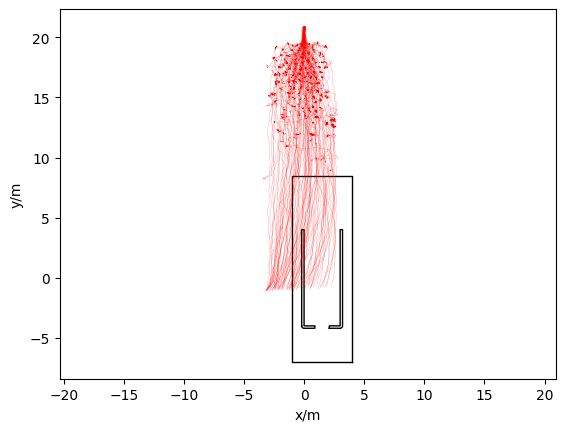

In [11]:
pedpy.plot_trajectories(traj=traj, traj_width=0.1, geometry=geometry).axis('equal')

In [12]:
print(traj.data.frame.min())
print(traj.data.frame.max())

417
9217


In [13]:
traj.data.groupby(by='frame').size().reset_index(name='count').sort_values('count', ascending=False).head(10)

,frame,count
1772,2189,89
2368,2785,89
2357,2774,89
2358,2775,89
2359,2776,89
2360,2777,89
2361,2778,89
2362,2779,89
2363,2780,89
2364,2781,89


In [14]:
from pedpy.methods.method_utils import _compute_individual_movement

def compute_normal_vector(data, frame_range):
    movement = _compute_individual_movement(data, frame_range)
    movement['normal_vector_x'] = movement.apply(lambda x: -(x.start.y- x.end.y), axis=1)
    movement['normal_vector_y'] = movement.apply(lambda x: x.start.x-x.end.x, axis=1)
    return movement


In [15]:
def plot_ped(ax, frame_data, alpha=1):
    for _, ped_data in frame_data.iterrows():
        origin = ped_data[["X", "Y"]].values
        # print(origin)
        angle = np.rad2deg(np.arctan2(ped_data['normal_vector_x'], ped_data['normal_vector_y']))
        # print(angle)
        # body = Ellipse(origin, 0.2, 0.45, color="gray",  angle=angle, alpha=alpha)
        # head = Ellipse(origin, 0.175, 0.2, color="black",  angle=angle,  alpha=alpha)
        body = Ellipse(origin, 0.3, 0.5, facecolor="gray",  angle=angle, alpha=alpha, edgecolor="k")
        head = Ellipse(origin, 0.25, 0.18, color="black",  angle=angle,  alpha=alpha)
    # body = Ellipse(origin, 0.3, 0.5, color="gray", angle=angle, alpha=alpha)
    # head = Ellipse(origin, 0.275, 0.2, color="black", angle=angle, alpha=alpha)
        ax.add_patch(body)
        ax.add_patch(head)
        ax.scatter(*origin, color="white", s=25)

In [16]:
measurement_line_top = shapely.LineString([[0, 3.5], [3, 3.5]])
measurement_line_bot = shapely.LineString([[0, 0.5], [3, 0.5]])
measurement_area = shapely.Polygon([[0.5, -1.5], [2.5, -1.5], [2.5, -3.5], [0.5, -3.5]])

# Plot picture middle

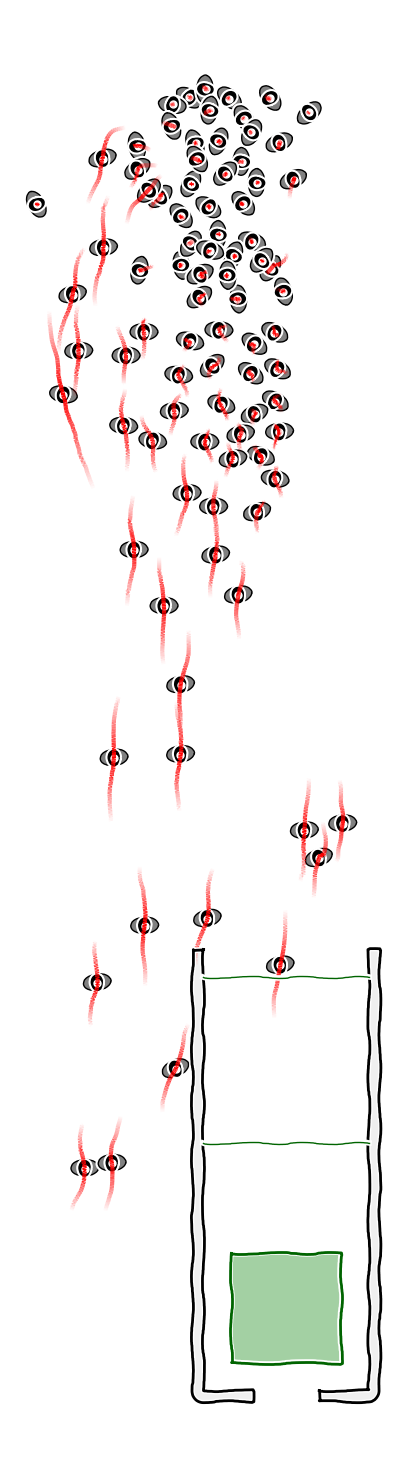

In [17]:
from matplotlib.collections import LineCollection
import matplotlib.colors as colors

with plt.xkcd(randomness=0.15):
    fig = plt.figure(figsize=[5, 20])
    ax = fig.add_subplot(111, aspect="equal")

    frame = 1521
    frame_range = 40

    redfade = colors.to_rgb("red") + (0.0,)
    myred = colors.LinearSegmentedColormap.from_list('my',[redfade, "red"])

    peds_in_frame = traj.data[traj.data.frame == frame]
    peds_in_frame_range = traj.data[traj.data.frame.between(frame-frame_range, frame+frame_range, inclusive='both')]
    # peds_in_frame_range = traj.data[(traj.data.frame.between(frame-frame_range, frame+frame_range, inclusive='both'))&(traj.data.ID.isin(peds_in_frame.ID))]

    ax.plot(*measurement_area.exterior.xy, color="darkgreen", linewidth=2)
    ax.fill(*measurement_area.exterior.xy, color="green", alpha=0.2)

    movement = compute_normal_vector(peds_in_frame_range, 20)
    peds_in_frame = peds_in_frame.merge(movement, on=["ID", "frame"])
    plot_ped(ax, peds_in_frame)

    for ped_id, ped_data in peds_in_frame_range.groupby(by='ID'):
        if not ped_id in peds_in_frame.ID.values:
            continue
        ped_data = ped_data.sort_values('frame')
        frame_pos = ped_data[ped_data.frame == frame].points.values[0]

        alphas = np.abs(1-np.abs(frame-ped_data.frame)/frame_range)


        points = np.vstack((ped_data.X, ped_data.Y)).T.reshape(-1, 1, 2)
        segments = np.hstack((points[:-1], points[1:]))

        lc = LineCollection(segments, array=alphas, cmap=myred, lw=3)
        line = ax.add_collection(lc)

    for hole in [obstacle_left, obstacle_right]:
        ax.plot(*hole.exterior.xy, color="k", linewidth=2)
        ax.fill(*hole.exterior.xy, color="lightgray", alpha=0.2)


    ax.plot(*measurement_line_top.xy, lw=1, color="darkgreen")
    ax.plot(*measurement_line_bot.xy, lw=1, color="darkgreen")
    plt.axis('off')
    # plt.savefig("poster/middle.svg", dpi=300, bbox_inches='tight')

# Flow

In [18]:
nt, crossing = pedpy.compute_n_t(traj_data=traj.data, measurement_line=measurement_line_top, frame_rate=traj.frame_rate)
individual_speed = pedpy.compute_individual_velocity(traj_data=traj.data, frame_rate=traj.frame_rate, frame_step=traj.frame_rate)
delta_t = int(1 * traj.frame_rate)

flow = pedpy.compute_flow(
    nt=nt,
    crossing_frames=crossing,
    individual_speed=individual_speed,
    delta_t=delta_t,
    frame_rate=traj.frame_rate,
)

findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfo

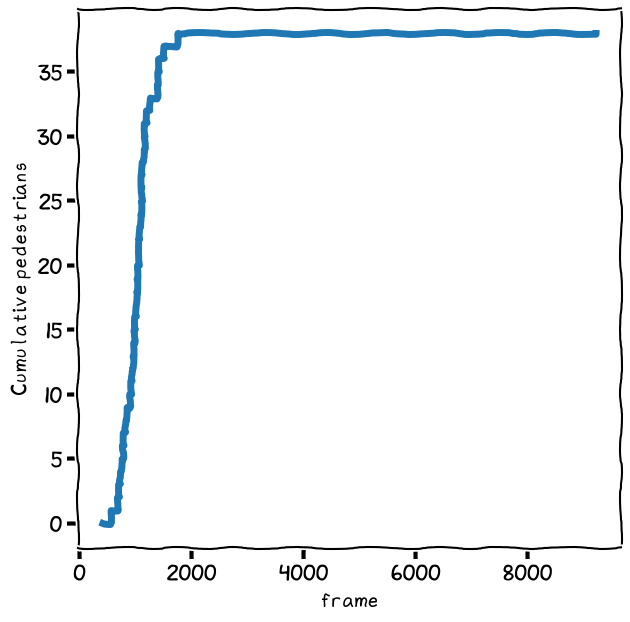

In [19]:
with plt.xkcd(randomness=0.15):
    fig = plt.figure(figsize=(7, 7))
    ax1 = fig.add_subplot(111)

    ax1.plot(nt.index, nt["Cumulative pedestrians"], lw=5)
    ax1.set_xlabel('frame')
    ax1.set_ylabel('Cumulative pedestrians')

    # ax1.legend()
    plt.show()

findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfo

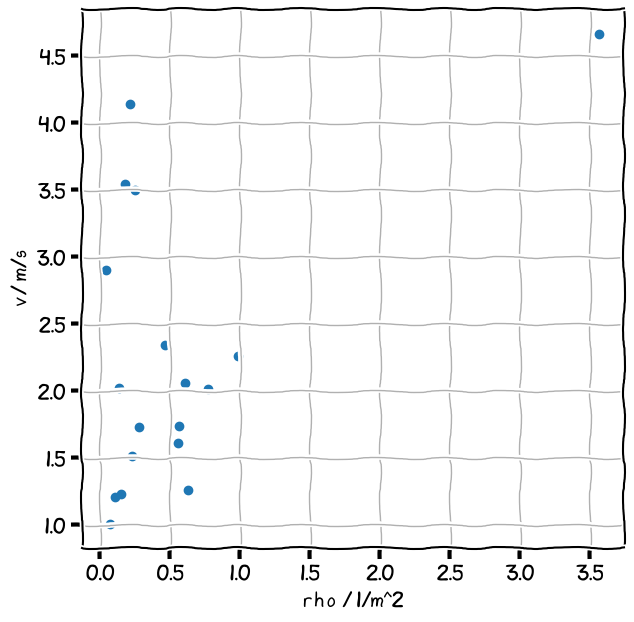

In [20]:
with plt.xkcd(randomness=0.15):
    fig = plt.figure(figsize=(7, 7))
    ax1 = fig.add_subplot(111)
    ax1.grid(True, linewidth=1)

    ax1.scatter(
        flow["Flow rate(1/s)"]
        / (flow["Mean velocity(m/s)"] * measurement_line_top.length),
        flow["Mean velocity(m/s)"],
    )

# ax0.set_xlim(left=0, right=4)
# ax0.set_ylim(bottom=0, top=2.5)

    ax1.set_xlabel("rho / 1/m^2")
    ax1.set_ylabel("v/ m/s")
# ax0.legend()

# Velocity

In [21]:
peds_in_frame[peds_in_frame.X < 0.1].head(10)

,ID,frame,X,Y,Z,points,start,end,start_frame,end_frame,normal_vector_x,normal_vector_y
0,1,1521,-0.140351,18.623618,1.730,POINT (-0.1403509593981371 18.6236175304514),POINT (-0.1602259333651779 18.62884306185813),POINT (-0.1285921562932887 18.618891569142583),1501.0,1541.0,-0.009951,-0.031634
1,2,1521,-0.254200,19.463071,1.660,POINT (-0.2542000836653386 19.463070996015936),POINT (-0.2546723102257636 19.48206913678619),POINT (-0.2206785144754316 19.434955378486052),1501.0,1541.0,-0.047114,-0.033994
2,3,1521,-0.560645,19.332448,1.775,POINT (-0.5606448443457822 19.332448341603552),POINT (-0.5671037790545834 19.35513917471925),POINT (-0.5541020015669887 19.299563306346307),1501.0,1541.0,-0.055576,-0.013002
6,7,1521,-0.568243,18.940352,1.760,POINT (-0.5682427274189226 18.940351862771376),POINT (-0.6939573639774859 18.987060600375237),POINT (-0.502712352184401 18.91580790672742),1501.0,1541.0,-0.071253,-0.191245
15,16,1521,-0.217073,17.881800,1.910,POINT (-0.217073 17.8818),POINT (-0.218664 17.8793),POINT (-0.210566 17.8842),1501.0,1541.0,0.004900,-0.008098
17,18,1521,-0.779592,17.648800,1.790,POINT (-0.779592 17.6488),POINT (-0.864612 17.5586),POINT (-0.75701 17.6981),1501.0,1541.0,0.139500,-0.107602
19,20,1521,-0.414691,16.409600,1.800,POINT (-0.414691 16.4096),POINT (-0.391719 16.4048),POINT (-0.410162 16.4068),1501.0,1541.0,0.002000,0.018443
23,24,1521,0.096840,17.475400,1.660,POINT (0.0968401 17.4754),POINT (0.0800723 17.4919),POINT (0.102493 17.4626),1501.0,1541.0,-0.029300,-0.022421
24,25,1521,-0.415507,17.301900,1.860,POINT (-0.415507 17.3019),POINT (-0.386537 17.2811),POINT (-0.406487 17.2968),1501.0,1541.0,0.015700,0.019950
27,28,1521,-1.405940,14.762700,1.750,POINT (-1.40594 14.7627),POINT (-1.43759 14.4919),POINT (-1.45765 15.0368),1501.0,1541.0,0.544900,0.020060


# Density

In [22]:
from pedpy import compute_individual_voronoi_polygons

individual_cutoff = compute_individual_voronoi_polygons(
    traj_data=traj.data, geometry=geometry, cut_off=(1.0, 12)
)

/home/tobias/development/pedpy/pedpy-venv/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/development/pedpy/pedpy-venv/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/development/pedpy/pedpy-venv/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/development/pedpy/pedpy-venv/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in intersection
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tobias/development/pedpy/pedpy-venv/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in inters

IndexError: index 0 is out of bounds for axis 0 with size 0

## Classic density

In [ ]:
peds_in_frame

In [ ]:
with plt.xkcd(randomness=0.15):
    fig = plt.figure(figsize=[5, 20])
    ax = fig.add_subplot(111, aspect="equal")

    ax.plot(*measurement_area.exterior.xy, color="darkgreen", linewidth=2)
    ax.fill(*measurement_area.exterior.xy, color="green", alpha=0.2)

    for hole in [obstacle_left, obstacle_right]:
        ax.plot(*hole.exterior.xy, color="k", linewidth=2)
        ax.fill(*hole.exterior.xy, color="lightgray", alpha=0.2)

    plot_ped(ax, peds_in_frame[shapely.contains(measurement_area, peds_in_frame['points'])])
    plot_ped(ax, peds_in_frame[~shapely.contains(measurement_area, peds_in_frame['points'])], 0.2)
    ax.set_xlim([-2, 5])
    ax.set_ylim([-7, 9])

    plt.axis('off')


## Voronoi Density

In [ ]:
peds_with_polys = peds_in_frame.merge(individual_cutoff, on=["ID", 'frame'])

with plt.xkcd(randomness=0.15):
    fig = plt.figure(figsize=[5, 20])
    ax = fig.add_subplot(111, aspect="equal")

    ax.plot(*measurement_area.exterior.xy, color="darkgreen", linewidth=2)
    # ax.fill(*measurement_area.exterior.xy, color="green", alpha=0.2)

    for hole in [obstacle_left, obstacle_right]:
        ax.plot(*hole.exterior.xy, color="k", linewidth=2)
        ax.fill(*hole.exterior.xy, color="lightgray", alpha=0.2)

    peds_outside = peds_with_polys[~shapely.intersects(measurement_area, peds_with_polys['individual voronoi'])]
    for _, ped in peds_outside.iterrows():
        ax.plot(*ped['individual voronoi'].exterior.xy, color="darkblue", linewidth=2, alpha=0.2)
        ax.fill(*ped['individual voronoi'].exterior.xy, color="lightblue", alpha=0.1)

    peds_inside = peds_with_polys[shapely.intersects(measurement_area, peds_with_polys['individual voronoi'])]
    for _, ped in peds_inside.iterrows():
        ax.plot(*ped['individual voronoi'].exterior.xy, color="darkblue", linewidth=2)
        ax.fill(*ped['individual voronoi'].exterior.xy, color="lightblue", alpha=0.5)

    plot_ped(ax, peds_outside, 0.2)
    plot_ped(ax, peds_inside)

    ax.set_xlim([-2, 5])
    ax.set_ylim([-7, 9])
    plt.axis('off')


# Neighborhood

In [ ]:
from pedpy import compute_neighbors

neighbors = compute_neighbors(individual_cutoff)
neighbors


In [ ]:
with plt.xkcd(randomness=0.15):

    voronoi_neighbors = individual_cutoff[individual_cutoff.frame == frame].merge(
        neighbors,
        on=["ID", "frame"],
    ).merge(peds_in_frame, on=["ID", 'frame'])

    for base in voronoi_neighbors["ID"].values[23:24]:
        base_neighbors = voronoi_neighbors[voronoi_neighbors["ID"] == base][
            "neighbors"
        ].values[0]

        fig = plt.figure(f"frame = {frame}", figsize=(20, 10))

        ax = fig.add_subplot(111, aspect="equal")
        # fig.suptitle(f"id = {base}")

        for _, row in voronoi_neighbors.iterrows():
            poly = row["individual voronoi"]
            ped_id = row["ID"]

            are_neighbors = ped_id in base_neighbors

            color = "lightgray"
            if ped_id == base:
                color = "green"

            if are_neighbors:
                color = "red"

            ax.plot(*poly.exterior.xy, alpha=1, color=color)
            ax.fill(*poly.exterior.xy, alpha=0.5, color=color)

        for hole in [obstacle_left, obstacle_right]:
            ax.plot(*hole.exterior.xy, color="k", linewidth=2)
            ax.fill(*hole.exterior.xy, color="darkgray", alpha=0.2)
        # plot_ped(ax, peds_in_frame)

        plot_ped(ax, voronoi_neighbors[~voronoi_neighbors.ID.isin(base_neighbors)], 0.2)
        plot_ped(ax, voronoi_neighbors[(voronoi_neighbors.ID.isin(base_neighbors))])
        plot_ped(ax, voronoi_neighbors[voronoi_neighbors.ID == base])

        ax.set_xlim([-1, 4])
        ax.set_ylim([-5, 1])
        fig.tight_layout()
        plt.axis('off')
        plt.show()


In [ ]:
voronoi_neighbors

# Profiles

In [ ]:
from pedpy.methods.profile_calculator import compute_profiles, VelocityMethod
from pedpy.methods.velocity_calculator import compute_individual_velocity, \
    compute_voronoi_velocity
from pedpy.methods.density_calculator import compute_voronoi_density

voronoi_density_frames, individual_frames = compute_voronoi_density(
    individual_voronoi_data=individual_cutoff,
    measurement_area=measurement_area,
)

individual_velocity = compute_individual_velocity(
    traj_data=traj.data, frame_rate=traj.frame_rate, frame_step=5
)
voronoi_velocity_frames = compute_voronoi_velocity(
    traj_data=traj.data,
    individual_voronoi_intersection=individual_frames,
    individual_velocity=individual_velocity,
    measurement_area=measurement_area,
)

density_profiles, velocity_profiles = compute_profiles(
    individual_voronoi_velocity_data=individual_frames.merge(
        individual_velocity,
        on=["ID", "frame"],
        how="left",
    ),
    walkable_area=geometry.walkable_area,
    grid_size=0.25,
    velocity_method=VelocityMethod.VORONOI,
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

bounds = geometry.walkable_area.bounds
with plt.xkcd(randomness=0.15):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    ax0.set_title("Density")
    cm = ax0.imshow(
        np.mean(density_profiles[500:1500], axis=0),
        extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
        interpolation="None",
        cmap="jet",
        vmin=0,
        vmax=5,
    )
    fig.colorbar(cm, ax=ax0, shrink=0.3)
    # ax0.plot(*geometry.walkable_area.exterior.xy, color="w")
    for hole in [obstacle_left, obstacle_right]:
        ax0.plot(*hole.exterior.xy, color="w", linewidth=2)
        # ax.fill(*hole.exterior.xy, color="darkgray", alpha=0.2)

    ax1.set_title("Velocity")
    cm = ax1.imshow(
        np.mean(velocity_profiles[500:1500], axis=0),
        extent=[bounds[0], bounds[2], bounds[1], bounds[3]],
        interpolation="None",
        cmap="jet",
        vmin=0,
        vmax=1.5,
    )
    fig.colorbar(cm, ax=ax1, shrink=0.3)

    ax1.plot(*geometry.walkable_area.exterior.xy, color="w")
    for hole in [obstacle_left, obstacle_right]:
        ax1.plot(*hole.exterior.xy, color="w", linewidth=2)

    fig.tight_layout()

# Helper

## Rectangle svt

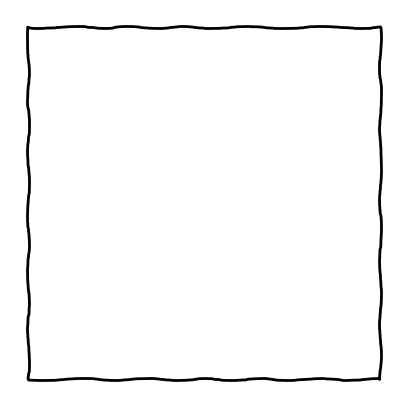

In [25]:
with plt.xkcd(randomness=0.15):
    fig = plt.figure(figsize=[5, 20])
    ax = fig.add_subplot(111, aspect="equal")

    ax.plot(*measurement_area.exterior.xy, color="k")
    plt.axis("off")
    plt.savefig('poster/rect.svg', dpi=300, bbox_inches='tight')
